Checking the mmul aligned dataset, such as for heterozygosity and whether the reference is a good proxy for the ancestral state

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
callset = zarr.open_group(zarr_dir.format("20"), mode="r")

First, a smaller sanity check to make sure I understand the mmul data correctly.

In [4]:
gt_zarr = allel.GenotypeArray(callset["calldata/GT"])

In [5]:
ac = gt_zarr.count_alleles()

In [6]:
ac.is_biallelic().sum()/len(ac)

0.781369969609213

Meanwhile, the number of biallelic sites in papio callset:

In [7]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chr{}"
callset = zarr.open_group(zarr_dir.format("20"), mode="r")
gt_zarr = allel.GenotypeArray(callset["calldata/GT"])
ac = gt_zarr.count_alleles()
ac.is_biallelic().sum()/len(ac)

0.954285550579864

In [8]:
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']
females = meta_data_samples.loc[meta_data_samples.Sex == "F"][6:].reset_index()
het_list = []
chr_list = []
size_list = []
ID_list = []
cluster_list = []
for chrom in chromosomes:
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/{}".format(chrom)
    callset = zarr.open_group(zarr_dir, mode="r")
    gt_zarr = allel.GenotypeArray(callset["calldata/GT"])
    gt_zarr = gt_zarr.take(females.callset_index.values, axis=1)
    het_state = gt_zarr.is_het()
    for i, row in females.iterrows():
        het_list.append(het_state[:, i].sum())
        size = callset["variants/POS"][-1]
        chr_list.append(chrom)
        size_list.append(size)
        ID_list.append(row.PGDP_ID)
        cluster_list.append(row.C_origin)
    print(chrom)
d = {"PGDP_ID": ID_list, "chrom": chr_list, "het_total": het_list, "chr_size": size_list, "C_origin": cluster_list}
het_df = pd.DataFrame(data=d)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [9]:
comp_chr = "chr7"
het_autosome_list = []
het_x_list = []
comp_chr_list = []
ID_list = []
cluster_list = []
for ID in het_df.PGDP_ID.unique():
    ID_df = het_df.loc[het_df.PGDP_ID == ID]
    other_autosomes = ID_df.loc[(ID_df.chrom != "chrX") & (ID_df.chrom != comp_chr)]
    het_autosome_list.append(other_autosomes["het_total"].sum()/(other_autosomes["chr_size"].sum()))
    chr_x = ID_df.loc[(ID_df.chrom == "chrX")]
    het_x_list.append(chr_x["het_total"].sum()/(chr_x["chr_size"].sum()))
    chr_comp = ID_df.loc[(ID_df.chrom == comp_chr)]
    comp_chr_list.append(chr_comp["het_total"].sum()/(chr_comp["chr_size"].sum()))
    ID_list.append(ID)
    cluster_list.append(ID_df.C_origin.unique()[0])
d = {"PGDP_ID": ID_list, "autosomal_het": het_autosome_list, "chrX_het": het_x_list,
     comp_chr+"_het": comp_chr_list, "C_origin": cluster_list}
chrX_vs_autosomes = pd.DataFrame(data=d)
chrX_vs_autosomes["X_autosome_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes["autosomal_het"]
chrX_vs_autosomes["X_comp_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes[comp_chr+"_het"]

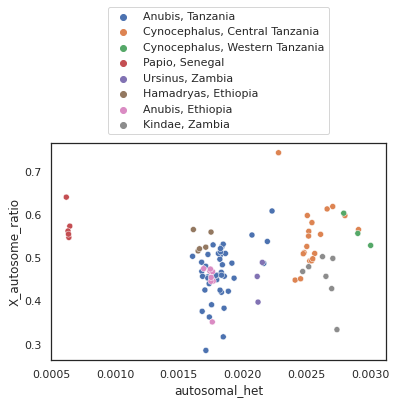

In [10]:
g = sns.scatterplot(data=chrX_vs_autosomes, x="autosomal_het", y="X_autosome_ratio", hue = "C_origin")
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65))